Resources:

- https://towardsdatascience.com/stable-diffusion-using-hugging-face-501d8dbdd8
- https://github.com/nateraw/stable-diffusion-videos

In [99]:
import os

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler, StableDiffusionPipeline

import requests
from tqdm import tqdm
from PIL import Image
from IPython.display import Image as ImageDisplay

/home/stepan/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [100]:
device_id = 1

In [3]:
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=1)

In [96]:
config = {
    'text_encoder_checkpoint': 'openai/clip-vit-large-patch14',
    'autoencoder_checkpoint': 'CompVis/stable-diffusion-v1-4', # 'stabilityai/stable-diffusion-2-1',
    'unet_checkpoint': 'CompVis/stable-diffusion-v1-4', #'stabilityai/stable-diffusion-2-1',
    'pipeline_checkpoint': 'CompVis/stable-diffusion-v1-4',
    'seed': None
}

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained(config['text_encoder_checkpoint'], torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained(config['text_encoder_checkpoint'], torch_dtype=torch.float16)
text_encoder.to(device)

In [7]:
if config['seed'] is not None:
    generator = [torch.Generator(device=device).manual_seed(config['seed'])]
else:
    generator = [torch.Generator(device=device)]

In [ ]:
vae = AutoencoderKL.from_pretrained(config['autoencoder_checkpoint'], subfolder='vae', torch_dtype=torch.float16)
vae.to(device)

In [25]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule='scaled_linear', num_train_timesteps=1000)
scheduler.set_timesteps(50)

In [ ]:
unet = UNet2DConditionModel.from_pretrained(config['unet_checkpoint'], subfolder='unet', torch_dtype=torch.float16)
unet.to(device)

In [27]:
def load_image(p):
    """
    Function to load images from a defined path
    """
    return Image.open(p).convert('RGB').resize((512,512))

def pil_to_latents(vae, image):
    """
    Function to convert image to latents
    """
    init_image = tfms.ToTensor()(image).unsqueeze(0) * 2.0 - 1.0
    init_image = init_image.to(device=device, dtype=torch.float16) 
    init_latent_dist = vae.encode(init_image).latent_dist.sample() * 0.18215
    return init_latent_dist

def latents_to_pil(vae, latents):
    """
    Function to convert latents to images
    """
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype('uint8')
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def text_enc(prompts, maxlen=None):
    """
    A function to take a texual promt and convert it into embeddings
    """
    if maxlen is None: maxlen = tokenizer.model_max_length
    inp = tokenizer(prompts, padding='max_length', max_length=maxlen, truncation=True, return_tensors='pt') 
    return text_encoder(inp.input_ids.to(device))[0].half()

In [91]:
def prompt_2_img(prompts, g=7.5, seed=100, steps=70, dim=512, save_int=False, show_int=False):
    """
    Diffusion process to convert prompt to image
    """
    
    # Defining batch size
    bs = len(prompts) 
    
    # Converting textual prompts to embedding
    text = text_enc(prompts) 
    
    # Adding an unconditional prompt , helps in the generation process
    uncond =  text_enc([''] * bs, text.shape[1])
    emb = torch.cat([uncond, text])
    
    # Setting the seed
    if seed: torch.manual_seed(seed)
    
    # Initiating random noise
    latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
    
    # Setting number of steps in scheduler
    scheduler.set_timesteps(steps)
    
    # Adding noise to the latents 
    latents = latents.to(device).half() * scheduler.init_noise_sigma
    
    # Iterating through defined steps
    for i,ts in enumerate(tqdm(scheduler.timesteps)):
        # We need to scale the i/p latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
        
        # Predicting noise residual using U-Net
        with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
            
        # Performing Guidance
        pred = u + g*(t-u)
        
        # Conditioning  the latents
        latents = scheduler.step(pred, ts, latents).prev_sample
        
        if show_int:
            plt.imshow(latents_to_pil(vae, latents)[0])
            plt.axis('off')
            plt.show()
        
        # Saving intermediate images
        if save_int: 
            if not os.path.exists(f'./steps'):
                os.mkdir(f'./steps')
            latents_to_pil(vae, latents)[0].save(f'steps/{i:04}.jpeg')
            
    # Returning the latent representation to output an image of 3x512x512
    return latents_to_pil(vae, latents)

In [29]:
prompt = ''
image_url = 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

In [30]:
data = requests.get(image_url).content

In [31]:
with open('assets/test.jpg','wb') as f:
    f.write(data)

In [32]:
img = load_image('assets/test.jpg')

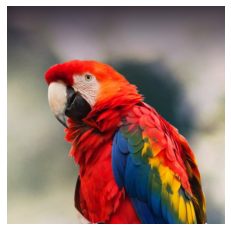

In [33]:
plt.imshow(img)
plt.axis('off')
plt.show()

/tmp/ipykernel_192550/2019103254.py:20: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((bs, unet.in_channels, dim//8, dim//8))
  0%|                                                     | 0/5 [00:00<?, ?it/s]

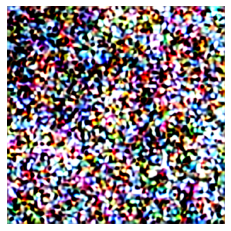

 20%|█████████                                    | 1/5 [00:00<00:00,  5.44it/s]

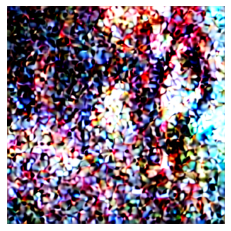

 40%|██████████████████                           | 2/5 [00:00<00:00,  5.42it/s]

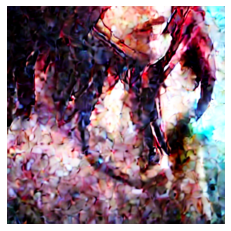

 60%|███████████████████████████                  | 3/5 [00:00<00:00,  5.43it/s]

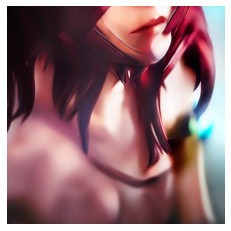

 80%|████████████████████████████████████         | 4/5 [00:00<00:00,  5.40it/s]

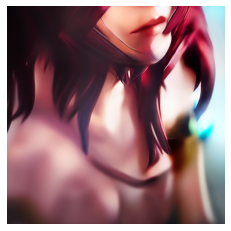

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00,  5.39it/s]


In [95]:
results = prompt_2_img(['Photo realistic Mikasa Ackerman as if she was a real person'], g=8, show_int=True, save_int=False, dim=512, steps=5, seed=100)

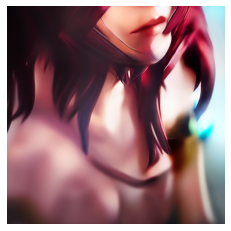

In [90]:
plt.imshow(results[0])
plt.axis('off')
plt.show()

In [151]:
def interpolate_gif(filesdir: list, resultfile: str, duration: int = 200):
    files = sorted(os.listdir(filesdir))
    
    images_list = []
    for file in files:
        img = load_image(f'{filesdir}/{file}')
        images_list.append(img)
    images_list = images_list + images_list[::-1] # loop back beginning

    images_list[0].save(
        f'assets/{resultfile}.gif',
        format='GIF',
        save_all=True,
        append_images=images_list[1:],
        duration=duration,
        loop=0)

In [88]:
interpolate_gif('./steps', resultfile='mikasa')

![mikasa](./assets/mikasa.gif)

In [153]:
@torch.no_grad()
def diffuse(
        pipe,
        cond_embeddings, # text conditioning, should be (1, 77, 768)
        cond_latents,    # image conditioning, should be (1, 4, 64, 64)
        num_inference_steps,
        guidance_scale,
    ):
    torch_device = cond_latents.get_device()

    # classifier guidance: add the unconditional embedding
    max_length = cond_embeddings.shape[1] # 77
    
    uncond_input = pipe.tokenizer([""], padding="max_length", max_length=max_length, return_tensors="pt")
    
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(torch_device))[0]
    
    text_embeddings = torch.cat([uncond_embeddings, cond_embeddings])

    # if we use LMSDiscreteScheduler, let's make sure latents are mulitplied by sigmas
    if isinstance(pipe.scheduler, LMSDiscreteScheduler):
        cond_latents = cond_latents * pipe.scheduler.sigmas[0]

    # diffuse!
    for i, t in enumerate(pipe.scheduler.timesteps):

        # expand the latents for classifier free guidance
        # TODO: gross much???
        latent_model_input = torch.cat([cond_latents] * 2)
        if isinstance(pipe.scheduler, LMSDiscreteScheduler):
            sigma = pipe.scheduler.sigmas[i]
            latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)

        # predict the noise residual
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # cfg
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # TODO: omfg...
        if isinstance(pipe.scheduler, LMSDiscreteScheduler):
            cond_latents = pipe.scheduler.step(noise_pred, i, cond_latents)["prev_sample"]
        else:
            cond_latents = pipe.scheduler.step(noise_pred, t, cond_latents)["prev_sample"]

    # scale and decode the image latents with vae
    return latents_to_pil(pipe.vae, cond_latents)

In [101]:
pipe = StableDiffusionPipeline.from_pretrained(config['pipeline_checkpoint'])
pipe.to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.12.1-git20200711.33e2d80-dfsg1-0.6 is an invalid version and will not be supported in a future release
  warnings.warn(


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [120]:
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    """ helper function to spherically interpolate two arrays v1 v2 """

    if not isinstance(v0, np.ndarray):
        inputs_are_torch = True
        input_device = v0.device
        v0 = v0.cpu().numpy()
        v1 = v1.cpu().numpy()

    dot = np.sum(v0 * v1 / (np.linalg.norm(v0) * np.linalg.norm(v1)))
    if np.abs(dot) > DOT_THRESHOLD:
        v2 = (1 - t) * v0 + t * v1
    else:
        theta_0 = np.arccos(dot)
        sin_theta_0 = np.sin(theta_0)
        theta_t = theta_0 * t
        sin_theta_t = np.sin(theta_t)
        s0 = np.sin(theta_0 - theta_t) / sin_theta_0
        s1 = sin_theta_t / sin_theta_0
        v2 = s0 * v0 + s1 * v1

    if inputs_are_torch:
        v2 = torch.from_numpy(v2).to(input_device)

    return v2

In [159]:
def stable_diffusion_dream(
        prompts, # prompts to dream about
        seeds=[243, 523],
        name = 'dreams', # name of this project, for the output directory
        rootdir = './dreams',
        num_steps = 72,  # number of steps between each pair of sampled points
        # --------------------------------------
        # args you probably don't want to change
        num_inference_steps = 50,
        guidance_scale = 7.5,
        eta = 0.0,
        width = 512,
        height = 512,
        show_int=False,
        # --------------------------------------
):
    assert len(prompts) == len(seeds)
    assert torch.cuda.is_available()
    assert height % 8 == 0 and width % 8 == 0

    # init the output dir
    outdir = os.path.join(rootdir, name)
    os.makedirs(outdir, exist_ok=True)
    

    # get the conditional text embeddings based on the prompts
    prompt_embeddings = []
    for prompt in prompts:   
        text_input = pipe.tokenizer(
            prompt,
            padding="max_length",
            max_length=pipe.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            embed = pipe.text_encoder(text_input.input_ids.to(device))[0]

        prompt_embeddings.append(embed)
    
    # Take first embed and set it as starting point, leaving rest as list we'll loop over.
    prompt_embedding_a, *prompt_embeddings = prompt_embeddings

    # Take first seed and use it to generate init noise
    init_seed, *seeds = seeds
    init_a = torch.randn(
        (1, pipe.unet.in_channels, height // 8, width // 8),
        device=device,
        generator=torch.Generator(device=device).manual_seed(init_seed)
    )
    
    pipe.scheduler.set_timesteps(num_inference_steps)
    
    frame_index = 0
    for p, prompt_embedding_b in enumerate(prompt_embeddings):

        init_b = torch.randn(
            (1, pipe.unet.in_channels, height // 8, width // 8),
            generator=torch.Generator(device='cuda').manual_seed(seeds[p]),
            device=device
        )

        for i, t in enumerate(tqdm(np.linspace(0, 1, num_steps))):
            # print("dreaming... ", frame_index)
            
            if not os.path.exists(f'{outdir}/frames'):
                os.mkdir(f'{outdir}/frames')

            cond_embedding = slerp(float(t), prompt_embedding_a, prompt_embedding_b)
            init = slerp(float(t), init_a, init_b)

            with torch.autocast("cuda"):
                image = diffuse(pipe, cond_embedding, init, num_inference_steps, guidance_scale)
            outpath = os.path.join(outdir, f'frames/{frame_index:04}.jpeg')
            image[0].save(outpath)
            frame_index += 1
            
            if show_int:
                plt.imshow(image[0])
                plt.axis('off')
                plt.show()

        prompt_embedding_a = prompt_embedding_b
        init_a = init_b

In [161]:
stable_diffusion_dream(
    prompts=['an anime styled image of a Mediterranean knight standing proudly in front of a majestic castle, capturing the essence of medieval chivalry and the beauty of the Mediterranean landscape', 
             'an anime styled futuristic warrior in Star Wars-inspired armor standing against a cosmic backdrop, showcasing the vastness of the galaxy or planets. Capture the essence of advanced technology and interstellar warfare in a single striking image'], 
    name='other',
    show_int=False, 
    seeds=[271, 1217],
    num_steps=160,
)

/tmp/ipykernel_192550/1292566711.py:47: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),
/tmp/ipykernel_192550/1292566711.py:58: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, height // 8, width // 8),
100%|█████████████████████████████████████████| 160/160 [08:06<00:00,  3.04s/it]


In [164]:
interpolate_gif('./dreams/other/frames', resultfile='warriors', duration=300)

![dogs](./assets/warriors.gif)